In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv('/kaggle/input/global-weather-repository/GlobalWeatherRepository.csv')
df

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.5200,69.1800,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.400,26.600,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.3300,19.8200,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.100,2.000,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.7600,3.0500,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.400,18.400,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.5000,1.5200,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.700,0.900,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.8400,13.2300,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.400,262.300,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59043,Venezuela,Caracas,10.5000,-66.9167,America/Caracas,1742119200,2025-03-16 06:00,24.1,75.4,Clear,...,16.465,19.980,2,2,06:34 AM,06:38 PM,08:33 PM,07:54 AM,Waning Gibbous,97
59044,Vietnam,Hanoi,21.0333,105.8500,Asia/Bangkok,1742119200,2025-03-16 17:00,21.2,70.2,Sunny,...,25.900,27.380,2,3,06:04 AM,06:06 PM,07:49 PM,07:00 AM,Waning Gibbous,98
59045,Yemen,Sanaa,15.3547,44.2067,Asia/Aden,1742119200,2025-03-16 13:00,23.6,74.5,Partly Cloudy,...,27.195,163.725,2,3,06:10 AM,06:13 PM,07:59 PM,07:16 AM,Waning Gibbous,98
59046,Zambia,Lusaka,-15.4167,28.2833,Africa/Lusaka,1742119200,2025-03-16 12:00,22.9,73.3,Patchy light drizzle,...,2.035,2.220,1,1,06:10 AM,06:20 PM,07:39 PM,07:40 AM,Waning Gibbous,98


In [4]:
#listing the missing values
df.isna().sum()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59048 entries, 0 to 59047
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       59048 non-null  object 
 1   location_name                 59048 non-null  object 
 2   latitude                      59048 non-null  float64
 3   longitude                     59048 non-null  float64
 4   timezone                      59048 non-null  object 
 5   last_updated_epoch            59048 non-null  int64  
 6   last_updated                  59048 non-null  object 
 7   temperature_celsius           59048 non-null  float64
 8   temperature_fahrenheit        59048 non-null  float64
 9   condition_text                59048 non-null  object 
 10  wind_mph                      59048 non-null  float64
 11  wind_kph                      59048 non-null  float64
 12  wind_degree                   59048 non-null  int64  
 13  w

In [6]:
num_cols = df.select_dtypes(include=[np.number]).columns

# Compute Q1, Q3, and IQR for each numerical column
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for winsorization
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Winsorize the data: cap values outside of the bounds
df_winsorized = df.copy()
for col in num_cols:
    df_winsorized[col] = np.where(
        df[col] < lower_bound[col], 
        lower_bound[col],
        np.where(df[col] > upper_bound[col], upper_bound[col], df[col])
    )

# Optionally, you can also identify outliers before handling:
outlier_mask = (df[num_cols] < lower_bound) | (df[num_cols] > upper_bound)
num_outliers = outlier_mask.sum()
print("Number of outliers per numerical column before winsorization:")
print(num_outliers)

In [7]:
# Recalculate IQR bounds for winsorized data
num_cols = df_winsorized.select_dtypes(include=[np.number]).columns
Q1_w = df_winsorized[num_cols].quantile(0.25)
Q3_w = df_winsorized[num_cols].quantile(0.75)
IQR_w = Q3_w - Q1_w
lower_bound_w = Q1_w - 1.5 * IQR_w
upper_bound_w = Q3_w + 1.5 * IQR_w

# Check for outliers in the winsorized data
outlier_mask_w = (df_winsorized[num_cols] < lower_bound_w) | (df_winsorized[num_cols] > upper_bound_w)
num_outliers_w = outlier_mask_w.sum()
print("Number of outliers per numerical column after winsorization:")
print(num_outliers_w)

In [8]:
# Initialize the scaler and fit-transform the numerical columns
scaler = StandardScaler()
df_normalized = df_winsorized.copy()
df_normalized[num_cols] = scaler.fit_transform(df_winsorized[num_cols])

# Check summary statistics of the normalized numerical data
print("Summary statistics of normalized data:")
print(df_normalized[num_cols].describe())

In [9]:
# df_normalized.info()

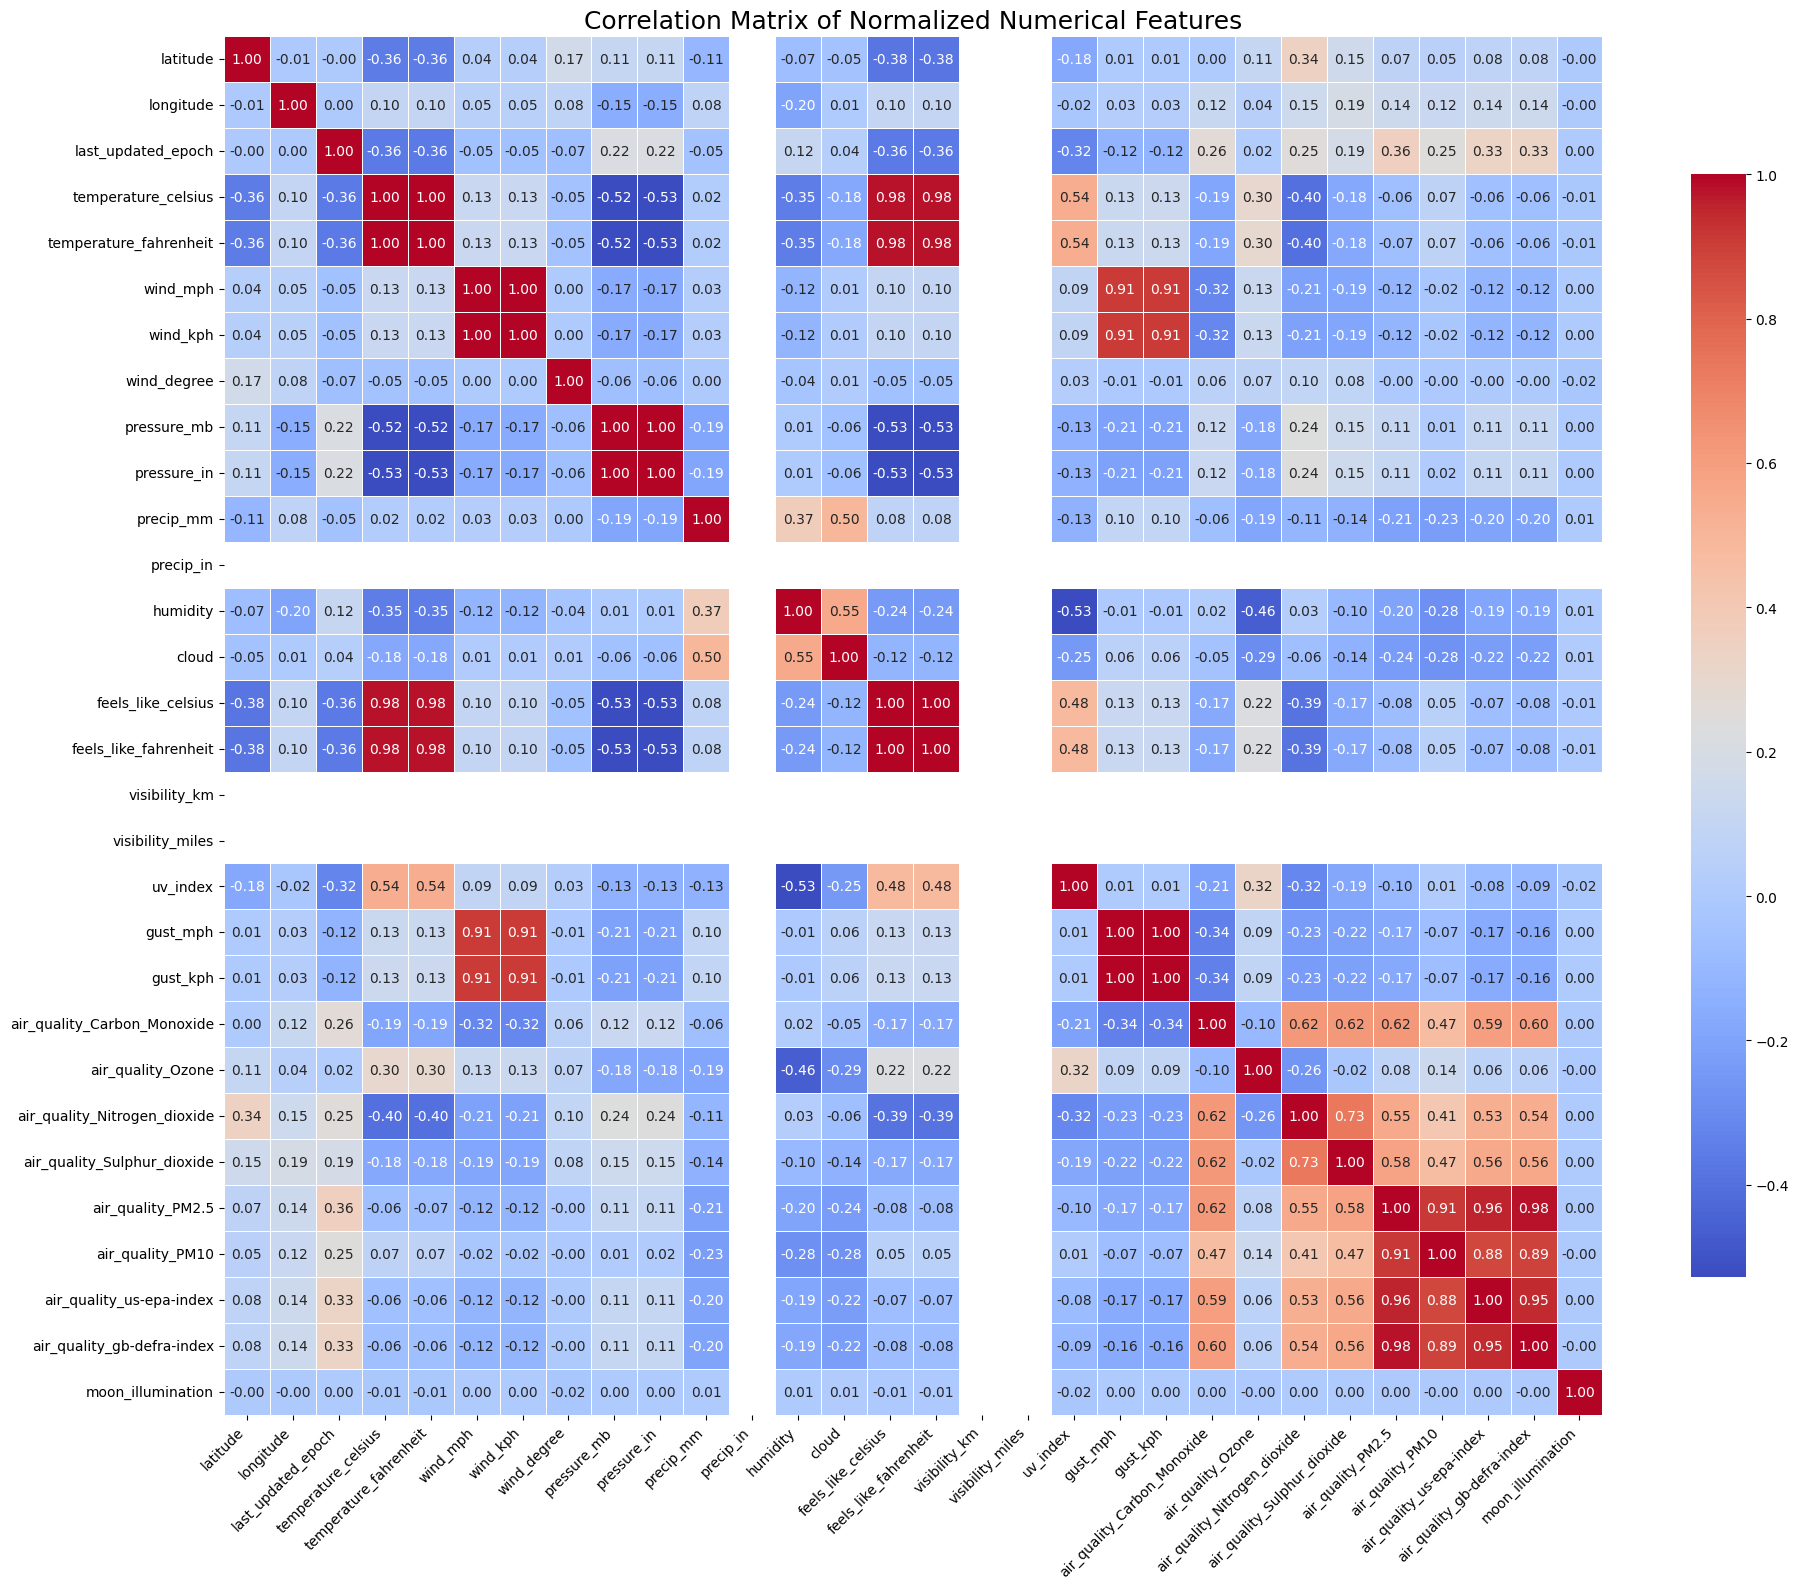

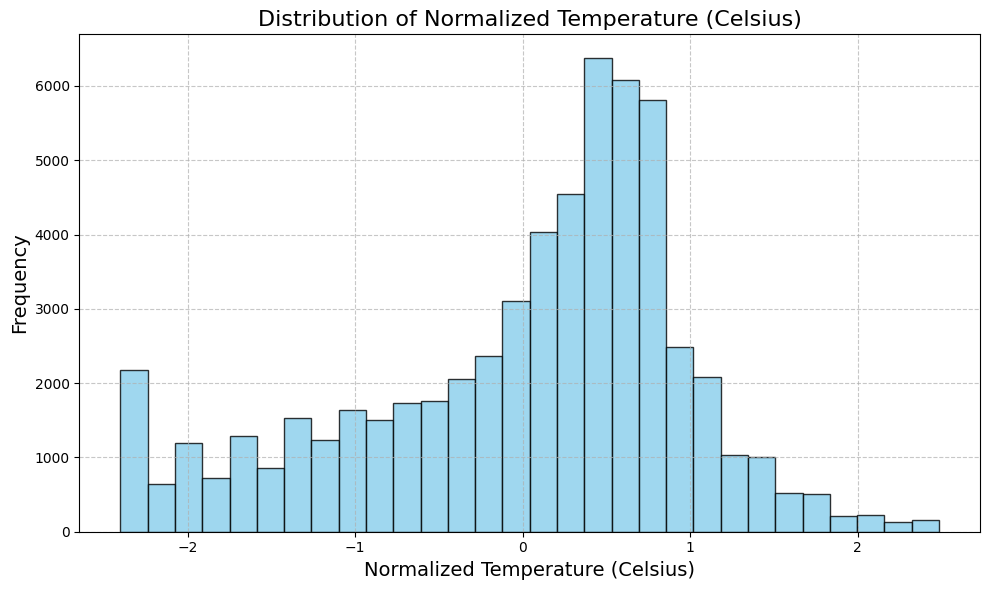

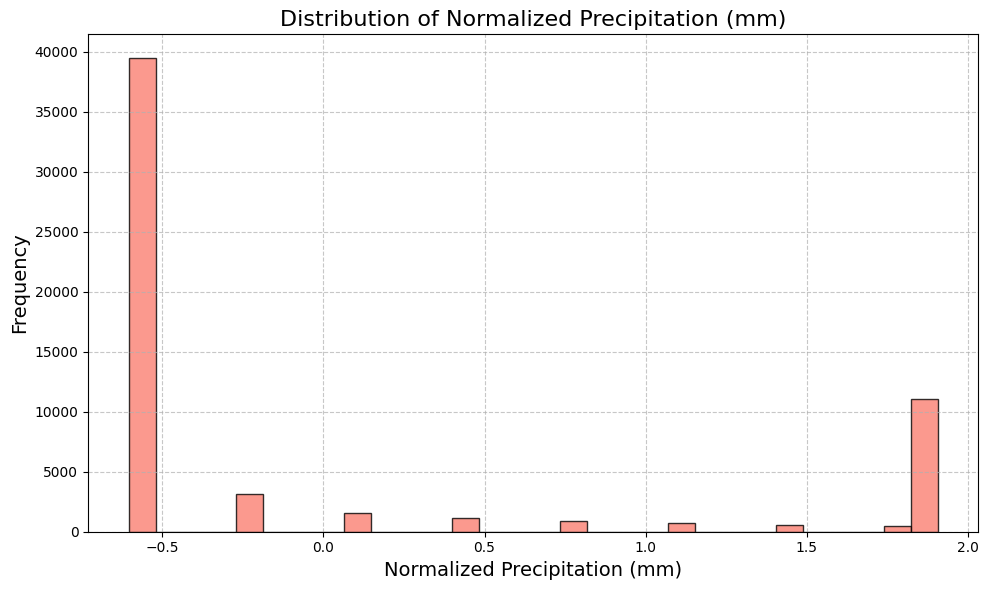

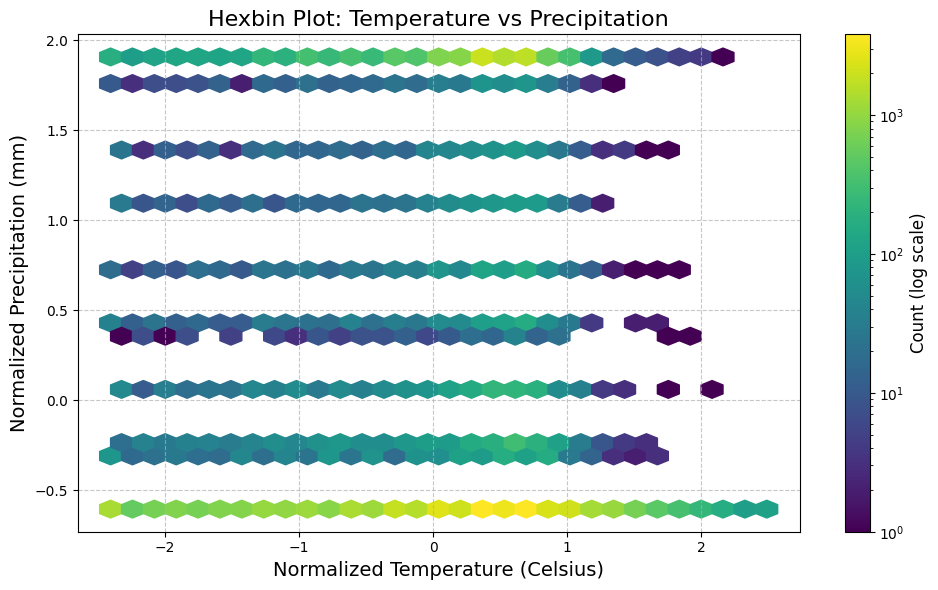

In [10]:
# Clip the numerical columns to the range [-3, 3] to avoid extreme values in plots
df_normalized[num_cols] = df_normalized[num_cols].clip(-3, 3)

# Compute the correlation matrix for numerical columns
corr_matrix = df_normalized[num_cols].corr()

# Increase figure size and adjust parameters for better visibility
plt.figure(figsize=(20, 16))
heatmap = sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    annot_kws={'fontsize':10},
    cbar_kws={'shrink': 0.8},
    square=True
)

# Adjust tick labels for clarity
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Correlation Matrix of Normalized Numerical Features", fontsize=18)
plt.tight_layout()
plt.show()

# Plot histogram for normalized Temperature (Celsius)
plt.figure(figsize=(10, 6))
plt.hist(df_normalized['temperature_celsius'], bins=30, color='skyblue', edgecolor='black', alpha=0.8)
plt.title("Distribution of Normalized Temperature (Celsius)", fontsize=16)
plt.xlabel("Normalized Temperature (Celsius)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot histogram for normalized Precipitation (mm)
plt.figure(figsize=(10, 6))
plt.hist(df_normalized['precip_mm'], bins=30, color='salmon', edgecolor='black', alpha=0.8)
plt.title("Distribution of Normalized Precipitation (mm)", fontsize=16)
plt.xlabel("Normalized Precipitation (mm)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Scatter plot to examine the relationship between Temperature and Precipitation
plt.figure(figsize=(10, 6))
plt.hexbin(
    df_normalized['temperature_celsius'],
    df_normalized['precip_mm'],
    gridsize=30,
    cmap='viridis',               # Use a high-contrast colormap
    mincnt=1,
    norm=colors.LogNorm()         # Logarithmic normalization for better visibility
)
cb = plt.colorbar()
cb.set_label('Count (log scale)', fontsize=12)
plt.title("Hexbin Plot: Temperature vs Precipitation", fontsize=16)
plt.xlabel("Normalized Temperature (Celsius)", fontsize=14)
plt.ylabel("Normalized Precipitation (mm)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Evaluation Metrics:
RMSE: 0.4674295340380102
MAE: 0.3599914322530181


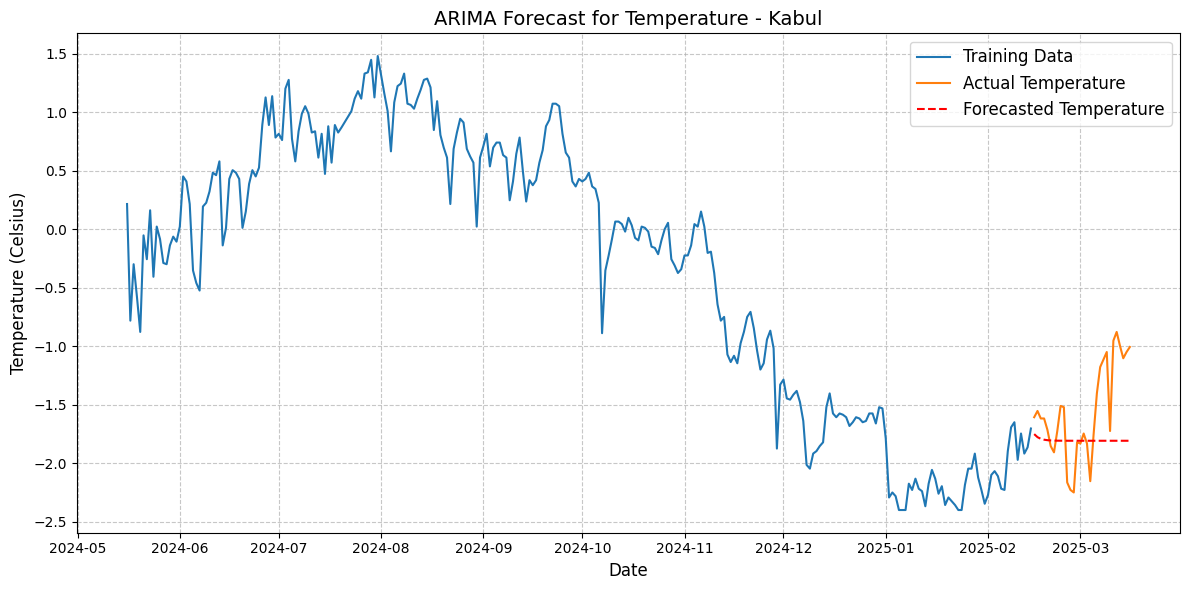

In [11]:
# === Data Preparation ===

# Convert 'last_updated' column to datetime (assumes a compatible format)
df_normalized['last_updated'] = pd.to_datetime(df_normalized['last_updated'])

# If the dataset covers multiple locations, select one for time series forecasting.
# Here, we use the first available location.
location = df_normalized['location_name'].iloc[0]
df_location = df_normalized[df_normalized['location_name'] == location].copy()

# Set 'last_updated' as the datetime index and sort the data
df_location = df_location.set_index('last_updated').sort_index()

# Resample the data to a daily frequency by taking the mean temperature per day.
# You can change 'temperature_celsius' to any target variable of interest.
daily_temp = df_location['temperature_celsius'].resample('D').mean().dropna()

# === Train-Test Split ===

# Split the data: Use all but the last 30 days for training and the final 30 days for testing.
train = daily_temp.iloc[:-30]
test = daily_temp.iloc[-30:]

# === Model Building: ARIMA ===

# Build a basic ARIMA model. Here, (1,1,1) is chosen as a starting point.
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the next 30 days (matching the test set)
forecast = model_fit.forecast(steps=30)

# === Model Evaluation ===

rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)

print("Evaluation Metrics:")
print("RMSE:", rmse)
print("MAE:", mae)

# === Plotting the Forecast ===

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Temperature')
plt.plot(test.index, forecast, label='Forecasted Temperature', color='red', linestyle='--')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (Celsius)", fontsize=12)
plt.title(f"ARIMA Forecast for Temperature - {location}", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


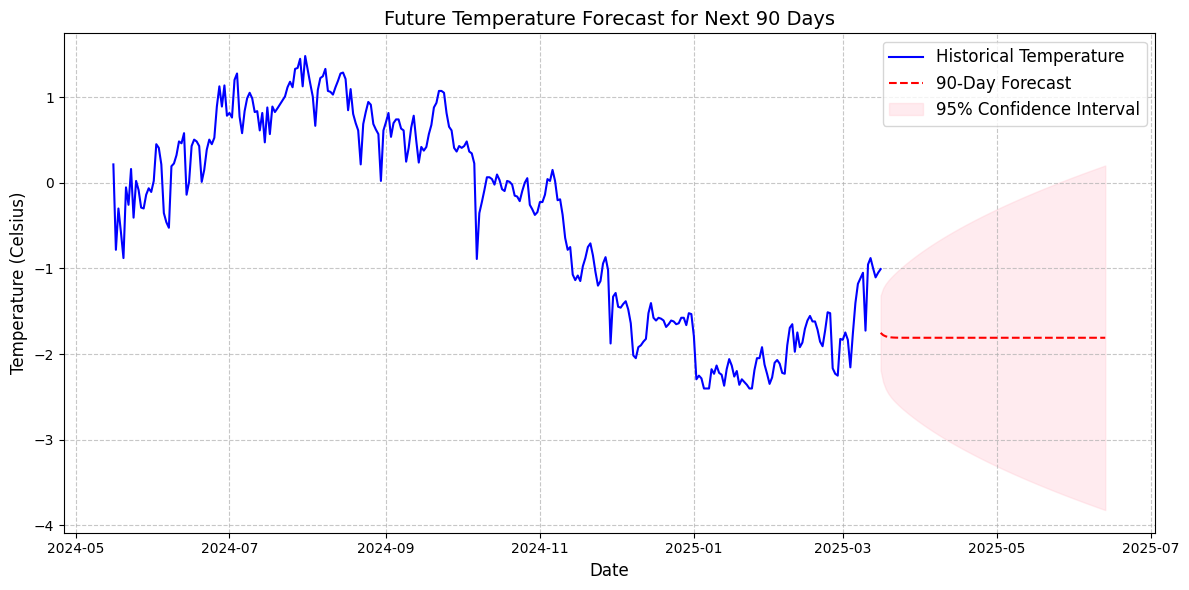

In [13]:
# ---------- Future Forecast: Next 90 Days ----------

# Forecasting the next 90 days beyond the historical data
forecast_obj_future = model_fit.get_forecast(steps=90)
forecast_90 = forecast_obj_future.predicted_mean
conf_int_90 = forecast_obj_future.conf_int()

# Create a date range for the future forecast
last_date = daily_temp.index[-1]
future_dates = pd.date_range(last_date, periods=90, freq='D')

plt.figure(figsize=(12, 6))
plt.plot(daily_temp.index, daily_temp, label='Historical Temperature', color='blue')
plt.plot(future_dates, forecast_90, label='90-Day Forecast', color='red', linestyle='--')
plt.fill_between(
    future_dates,
    conf_int_90.iloc[:, 0],
    conf_int_90.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (Celsius)", fontsize=12)
plt.title("Future Temperature Forecast for Next 90 Days", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
